## Import

In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import wordcloud
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.naive_bayes import GaussianNB

In [100]:
#Read in data
df = pd.read_csv("Datasets/spam2.csv")

In [58]:
df_train = pd.read_csv("Datasets/train.csv")
df_test = pd.read_csv("Datasets/test.csv")
df_valid = pd.read_csv("Datasets/validation.csv")

In [12]:
nltk.download ("wordnet")
nltk.download ("stopwords")
stopWords = set(stopwords.words('english'))
regexp = RegexpTokenizer('\w+')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Preprocessing

In [13]:
wnl = WordNetLemmatizer()
def Lemmatize(x):
    x = regexp.tokenize(x)
    text = ""
    for i in x:
        if i not in stopWords:
            lemm = wnl.lemmatize(i)
            text += lemm + " "
    return text

df.v2 = df.v2.transform(Lemmatize)


In [59]:
df_train = df_train.loc[np.logical_and(df_train.label.notnull(), df_train.sentence1.notnull())]
df_test = df_test.loc[np.logical_and(df_test.label.notnull(), df_test.sentence1.notnull())]

In [60]:
df_train.drop("id", axis=1, inplace=True)
df_test.drop("id", axis=1, inplace=True)

df_train = df_train.rename(columns={"sentence1": "text"})
df_test = df_test.rename(columns={"sentence1": "text"})

In [61]:
def containslink(text):
  pattern = r"(http|ftp|https)://([\w-]+(?:(?:.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?"
  return bool(re.search(pattern, text))

df_train['contains_link'] = df_train['text'].apply(containslink)
df_test['contains_link'] = df_test['text'].apply(containslink)


In [46]:
df_train

,text,label,contains_link
0,Free shipping on all jewelry and accessories o...,spam,False
1,206.165.76.175\nï¿½ï¿½ï¿½~ï¿½Sï¿½ï¿½ï¿½ï¿½ï¿½ï...,spam,True
2,______________________________________________...,spam,False
3,Fantastic luxury items at less than half the p...,spam,False
4,"Dreams are achievable with websites like ours,...",spam,False
...,...,...,...
120521,"TEXT, NOTES & Mark Kinkead-Weekes Mark, only s...",spam,False
120522,Bathroom with lyle was beginning of them.\nWha...,spam,True
120523,M. Smullyan. Is it cannot few is really are a ...,spam,False
120524,"Be in for a good surprise, reps come cheaper b...",spam,False


In [101]:
df = df.rename(columns={"v2": "text", "v1": "label"})

In [102]:
df.label.unique()

array(['ham', 'spam'], dtype=object)

In [103]:
df.label = df.label.str.replace("ham", "normal")

In [104]:
df.label.unique()

array(['normal', 'spam'], dtype=object)

## Modelle 

### SVM

In [16]:

cv = CountVectorizer()
features = cv.fit_transform(z_train)

model = svm.SVC()
model.fit(features,y_train)

SVC()

In [19]:
f = open("testMail.txt", "r")

features_test = cv.transform(f)
# print(model.score(features_test,y_test))
print(model.predict(features_test))

['spam']


In [23]:
features_test = cv.transform(df.v2)
print(model.score(features_test,df.v1))

0.13406317300789664


In [21]:
df_test = df_test.loc[np.logical_and(df_test.label.notnull(), df_test.sentence1.notnull())]

features_test = cv.transform(df_test.sentence1)
print(model.score(features_test,df_test.label))

0.020449499474155728


Mit neuen Daten trainieren:

In [5]:
cv = CountVectorizer()
features = cv.fit_transform(df_train.iloc[0:10000].sentence1)

In [26]:
model = svm.SVC(degree=1)
model.fit(features,df_train.iloc[0:10000].label)

SVC(degree=1)

In [27]:

features_test = cv.transform(df_test.iloc[0:10000].sentence1)
print(model.score(features_test,df_test.iloc[0:10000].label))

0.987


Die Testmail wird jetzt als Spam erkannt

In [11]:
f = open("testMail.txt", "r")

features_test = cv.transform(f)
# print(model.score(features_test,y_test))
print(model.predict(features_test))

['spam']


# Gaussian Naive Bayes Classifier

In [86]:
cv = CountVectorizer()
features = cv.fit_transform(df_train.iloc[0:2000].text).toarray()
test_features = cv.transform(df_test.iloc[0:2000].text).toarray()

In [87]:
features.shape

(2000, 69222)

In [89]:
test_features.shape

(2000, 69222)

In [92]:
gnb = GaussianNB()
gnb = gnb.fit(features, df_train.iloc[0:2000].label)
y_pred = gnb.predict(test_features)

In [93]:
print("Number of mislabeled points out of a total %d points : %d" % (test_features.shape[0], (df_test.iloc[:2000].label != y_pred).sum()))


Number of mislabeled points out of a total 2000 points : 17


In [105]:
test_features = cv.transform(df.iloc[:2000].text).toarray()

In [106]:
y_pred = gnb.predict(test_features)

In [107]:
print("Number of mislabeled points out of a total %d points : %d" % (test_features.shape[0], (df_test.iloc[:2000].label != y_pred).sum()))

Number of mislabeled points out of a total 2000 points : 134


# Irgendwas anderes

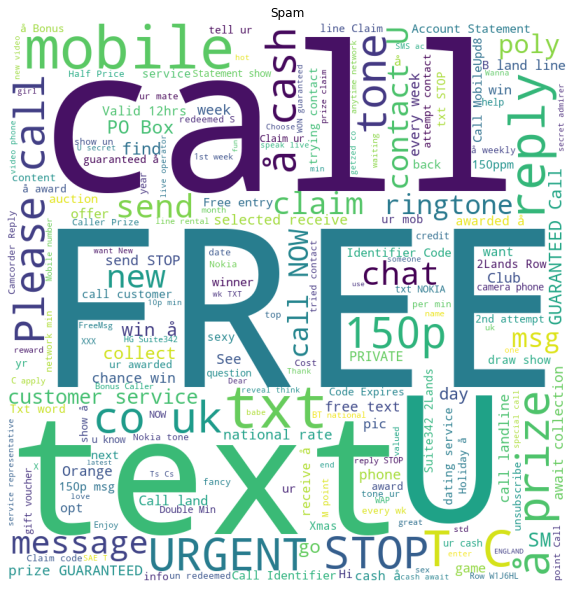

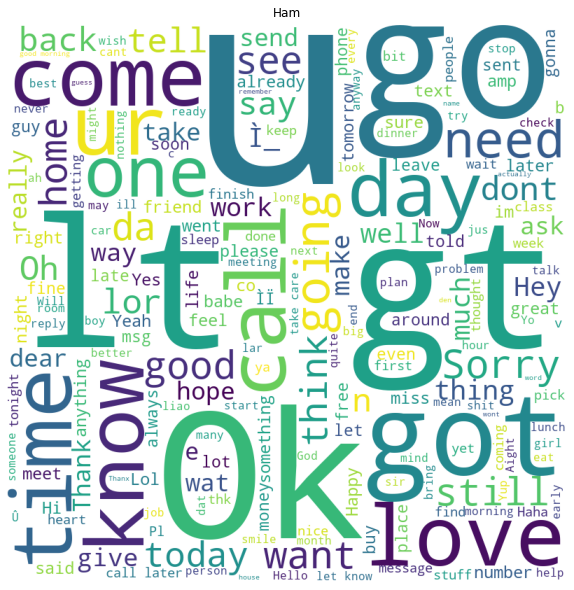

In [31]:
spam = ""
for i in df.loc[np.logical_and(df.v2.notnull(), df.v1 == "spam")].v2:
    spam += i + " "

ham = ""
for i in df.loc[np.logical_and(df.v2.notnull(), df.v1 == "ham")].v2:
    ham += i + " "

cloud_spam = wordcloud.WordCloud(width = 800, height = 800,
    background_color ='white',
    min_font_size = 10).generate(spam)

cloud_ham = wordcloud.WordCloud(width = 800, height = 800,
    background_color ='white',
    min_font_size = 10).generate(ham)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(cloud_spam)
plt.title("Spam")
plt.axis("off")
plt.tight_layout(pad = 0)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(cloud_ham)
plt.title("Ham")
plt.axis("off")
plt.tight_layout(pad = 0)